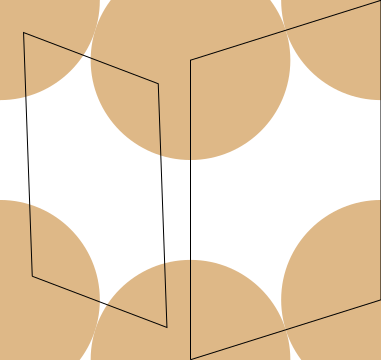

In [3]:
from sympy import *
from sympy.plotting import plot
import networkx as nx
import drawSvg as draw

circle_color = "#DEB887"
polygon_color = "black"
line_thickness = 0.1
precision = 10
    
def max_val (points):
    x = 0
    y = 0
    for point in points: 
        if point.x > x: x = point.x
        if point.y > y: y = point.y
    return float(x),float(y)
def drawCircle(c,d):
    d.append(draw.Circle(float(c.center.x),float(c.center.y),c.radius, fill= circle_color))
def drawPoly(p,d):
    path = draw.Path(stroke=polygon_color, stroke_width=line_thickness, fill='none')
    path.M(float(p.vertices[0].x), float(p.vertices[0].y))
    [path.L(float(v.x),float(v.y)) for v in p.vertices]
    path.L(float(p.vertices[0].x), float(p.vertices[0].y))
    d.append(path)
def shrink_polygon(polygon,sweep_length):
    b = polygon.bisectors(precision)
    new_vertices = []
    for vertex in polygon.vertices:
        new_vertices.append(vertex.translate((b[vertex].direction*sweep_length).x,(b[vertex].direction*sweep_length).y))
    return Polygon(*new_vertices)
T = nx.Graph()

points = Point(0,6), Point(0,36), Point(19.08,0),Point(19.08,30), Point(38.16,6), Point(38.16,36)
# TODO: make the size of circles the length in the tree
circles = [Circle(point,10) for point in points]


#TODO figure out again where the polygons come from
lang_polys = [convex_hull(*points[:4]),convex_hull(*points[2:])]

original = lang_polys[0]
lang_polys[0] = shrink_polygon(lang_polys[0],2)
lang_polys[0] = shrink_polygon(lang_polys[0],2)

#lang_polys.append(original)

w,h = max_val(points)
d = draw.Drawing (w,h)
for c in circles: drawCircle(c,d) 
for poly in lang_polys: drawPoly(poly,d)
scale = 10
d.setRenderSize(w*10,h*10)
d